In [1]:
%matplotlib inline

from collections import defaultdict
import collections

from shutil import copy ,copytree, rmtree
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import regularizers ,models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2




In [2]:
print(tf.__version__)


2.4.1



In [3]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
get_data_extract()


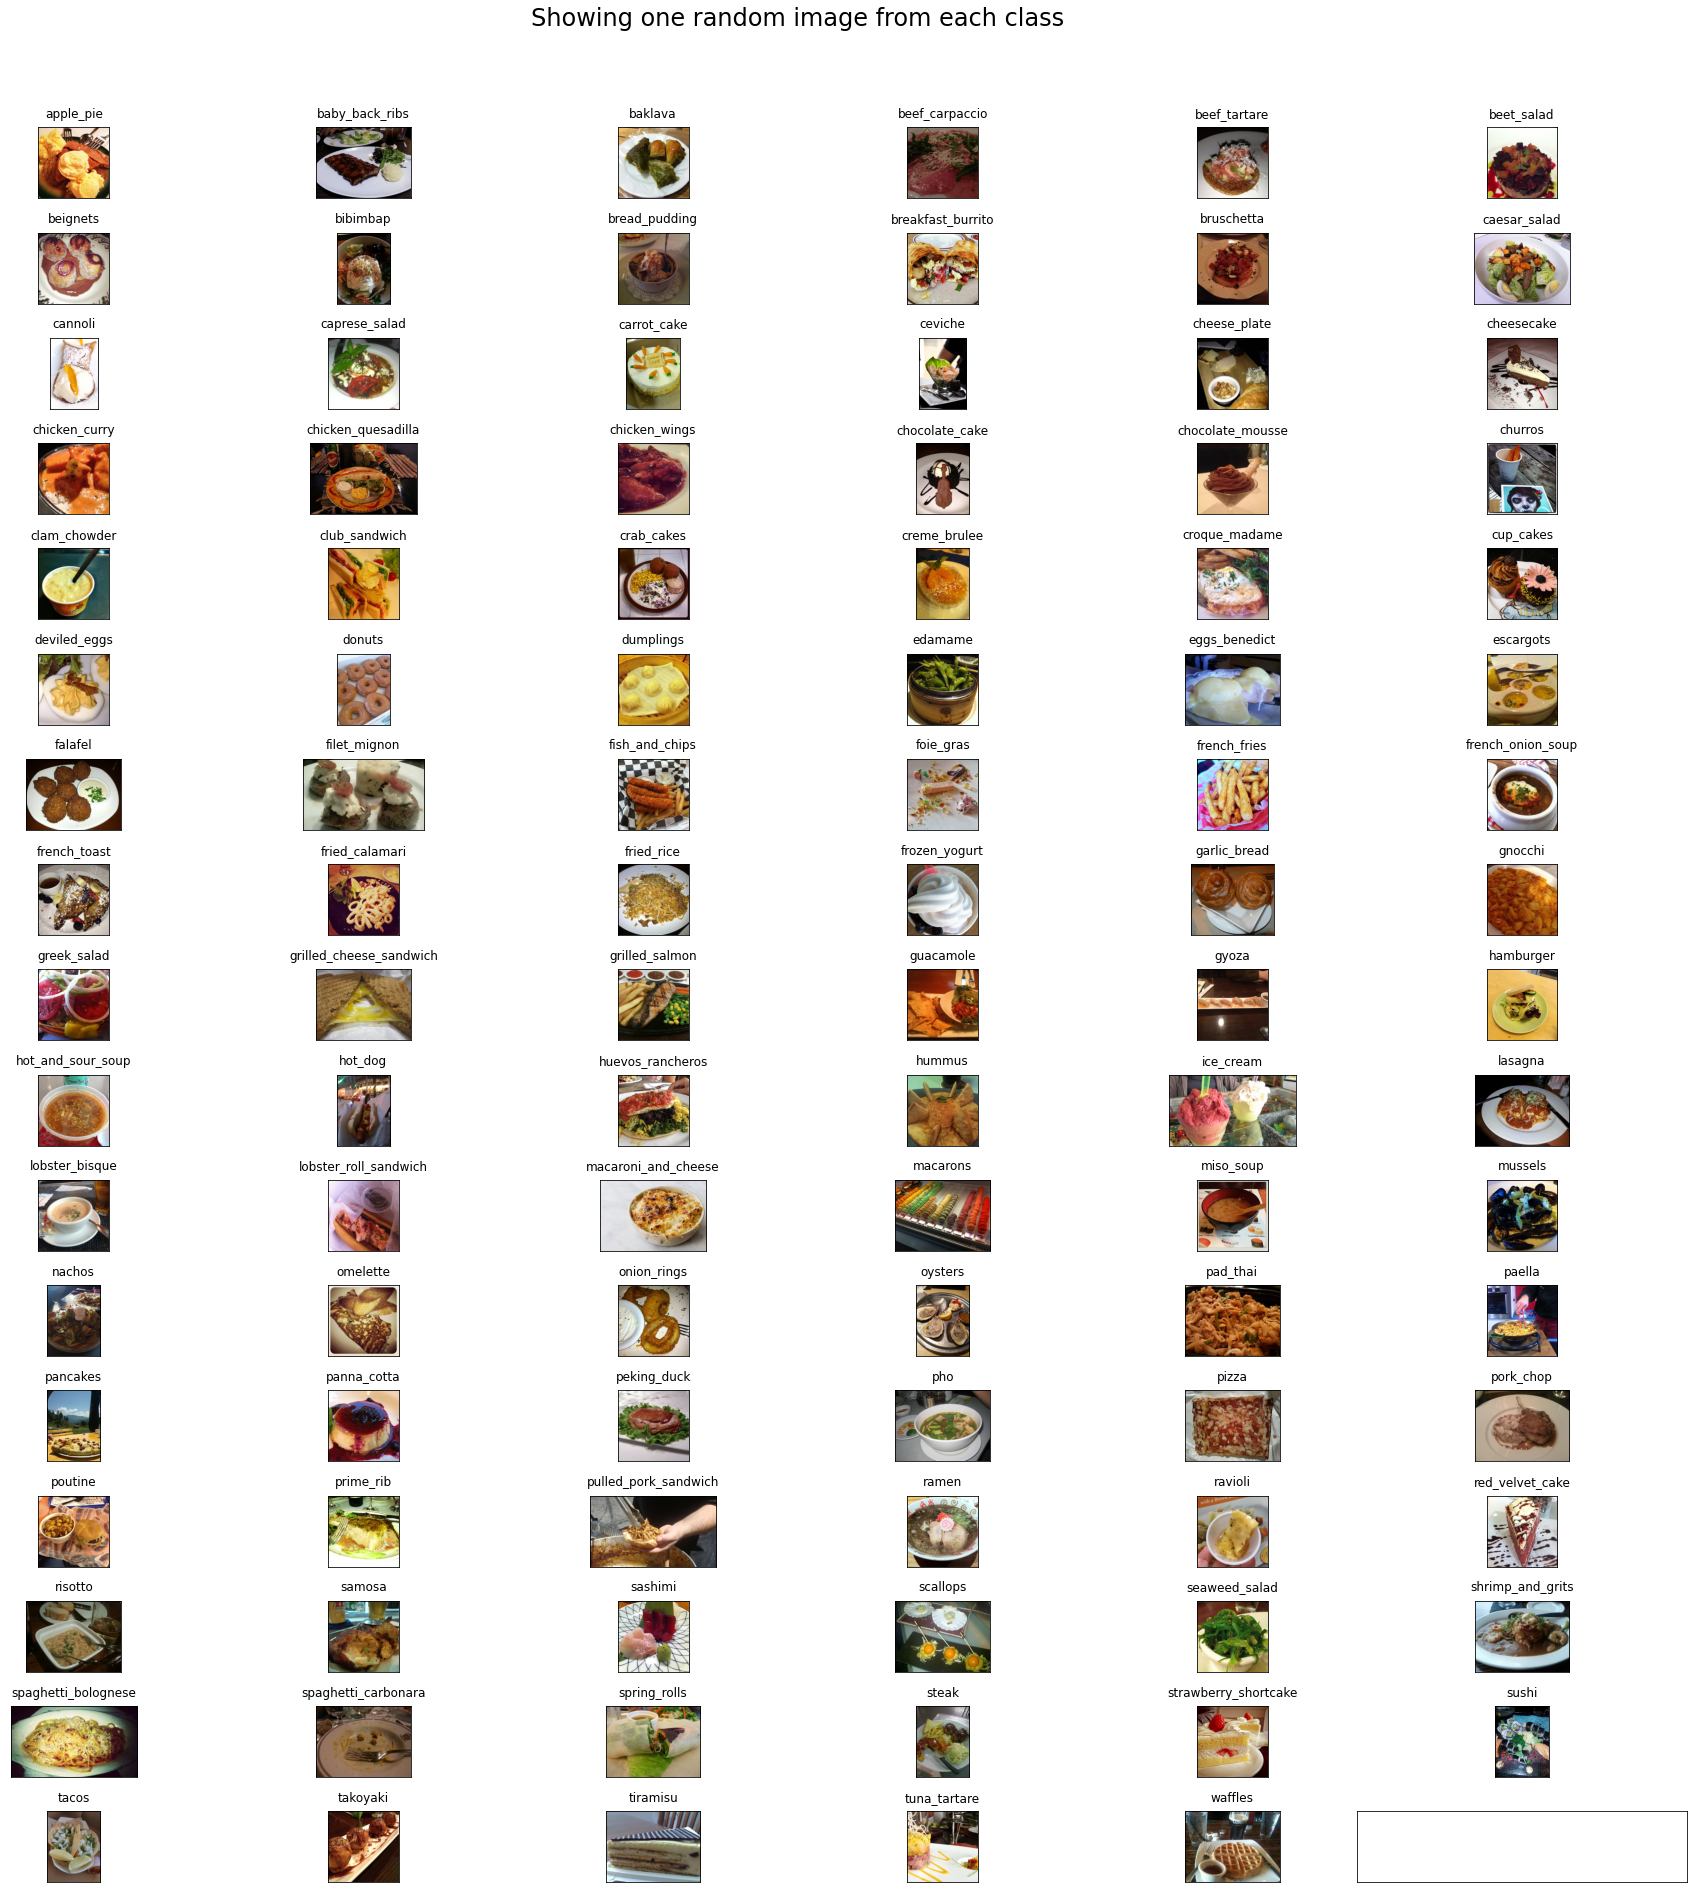

In [5]:

# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [6]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [7]:
print("Creating train data...")
prepare_data('./food-101/meta/train.txt', './food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
print("Creating test data...")
prepare_data('./food-101/meta/test.txt', './food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [ ]:
dataset_mini(food_list, src_train, dest_train)

Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
dataset_mini(food_list, src_test, dest_test)


Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87916544/87910968 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
140/140 [==============================] - 107s 468ms/step - loss: 1.1643 - accuracy: 0.4314 - val_loss: 0.8114 - val_accuracy: 0.7201

Epoch 00001: val_loss improved from inf to 0.81144, saving model to best_model_3class.hdf5
Epoch 2/30
140/140 [==============================] - 61s 432ms/step - loss: 0.8840 - accuracy: 0.6422 - val_loss: 0.6441 - val_accuracy: 0.8043

Epoch 00002: val_loss improved from 0.81144 to 0.64409, saving model to best_model_3class.hdf5
Epoch 3/30
140/140 [==============================] - 61s 432ms/step - loss: 0.6936 - accuracy: 0.7733 - val_loss: 0.5237 - val_accuracy: 0.8560

Epoch 00003: val_loss improved from 0.64409 to 0.52366, saving model to best_model_3class.hdf5
Epoch 4/30
140/140 [==============================] - 61s 434ms/step - loss: 0.6017 - accuracy: 0.7955 - val_loss: 0.4358 - val_accuracy: 0.8791

Epoch 00004: val_loss improved from 0.52366 to 0.43578, saving model to best_model_3class.hdf5
Epoch 5/30
140/140 [===================

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

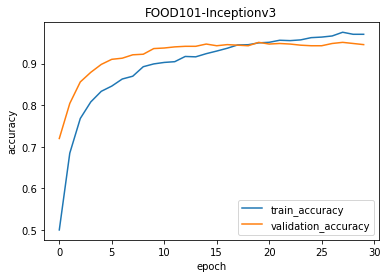

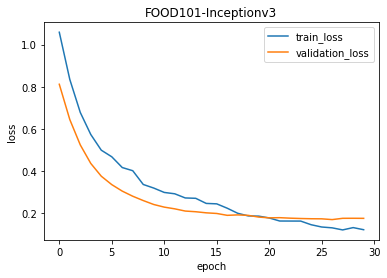

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
model_best = load_model('best_model_3class.hdf5',compile = False)


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    print(pred)
    
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value+str(pred[0][index]))
        plt.show()

In [ ]:
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
#!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files


--2021-03-31 07:43:21--  https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
Resolving www.publicdomainpictures.net (www.publicdomainpictures.net)... 104.20.44.162, 104.20.45.162, 172.67.2.204, ...
Connecting to www.publicdomainpictures.net (www.publicdomainpictures.net)|104.20.44.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51698 (50K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>]  50.49K  --.-KB/s    in 0s      

2021-03-31 07:43:21 (139 MB/s) - ‘cupcakes.jpg’ saved [51698/51698]

--2021-03-31 07:43:21--  https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4154557 (4.0M) [image/jpeg]
Saving to: ‘springrolls.jpg

[[0.8202676  0.05523742 0.12449497]]


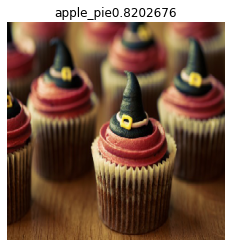

[[1.6520591e-02 9.8286718e-01 6.1232259e-04]]


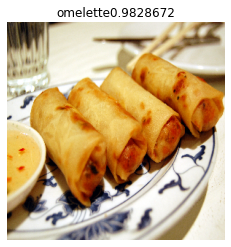

In [ ]:
images = []
images.append('cupcakes.jpg')
images.append('springrolls.jpg')
predict_class(model_best, images, True)